# EVAC Assessment 1 Code


In [228]:
import random
import time
import turtle
import numpy as np
from deap import base
from deap import creator
from deap import tools
import logging

In [229]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)
HEADLESS = True # True to run without graphical interface or False to run with the game showing

logging.basicConfig(level=logging.INFO) # Initializes the logging level used to output to console

In [230]:
class DisplayGame:
    """Class for displaying the game when HEADLESS is set to False"""

    def __init__(self, XSIZE, YSIZE):
        """Initializes all aspects of the game including the board, snake and food pellets."""
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVAC Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("red")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        """Resets the display when the game is first ran"""
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        """Updates/draws food to the display"""
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        """Updates/draws each segment of the snake to the display"""
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        """Draws and adds a new snake segment to the display"""
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color("green") # TODO: Change back to random colour generation before submission
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [231]:
class Snake:
    """Class which contains the game logic for the game Snake"""

    def __init__(self, _XSIZE, _YSIZE):
        """Draws and adds a new snake segment to the display"""
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        """Resets the game after a run has finished"""
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0]] # Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.snake_direction = "right"
        self.time_alive = 0 # TODO: 1. Check if this modification is allowed

    def place_food(self):
        """Randomly generates a location for the food, and regenerates it if spawned inside the snake"""
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        """Adds the new coordinate of the snakes head to the front of the snake coordinate list."""
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        """Returns True if snakes head coordinate is the same as the food location, otherwise removes the oldest coordinate 
            in the snake coordinate list (as a new one will be added for the movement of the head) and returns False."""
        if self.snake[0] == self.food:
            return True
        else:    
            self.snake.pop()  # snake moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        """Returns True if new snakes head coordinate is already in the body, otherwise False"""
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        """Returns True if new snakes head coordinate goes out of bounds, otherwise False"""
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Sensor Functions
    def get_adj_coord(self, direction):
        """Returns coordinate adjacent to the snakes head in the direction provided by the parameter"""
        dir_offsets = {"up": [-1, 0], ("down"): [+1, 0],
                   ("left"): [0, -1], ("right"): [0, +1]}

        return list(map(sum, zip(self.snake[0], dir_offsets[direction])))
        
    def sense_wall(self, coord):
        """Returns True if provided coordinate out of bounds, otherwise False"""
        return(coord[0] == 0 or coord[0] == (YSIZE-1) or coord[1] == 0 or coord[1] == (XSIZE-1))

    def sense_food(self, coord):
        """True if food is at provided coordinate, otherwise False"""
        return self.food == coord

    def sense_tail(self, coord):
        """Returns True if coordinate is a part of the snake, otherwise False"""
        return coord in self.snake
    
    def dist_to_food(self):
        """Calculates the manhattan distance to food""" # TODO: Check this works
        return abs(self.food[0]-self.snake[0][0]) + abs(self.food[1]-self.snake[0][1])
    
    def obstacle_check(self, direction):
        """Returns 0 if a tail or wall is found in a given direction, otherwise 1"""
        coord = self.get_adj_coord(direction)
        if self.sense_wall(coord):
            return 0
        elif self.sense_tail(coord):
            return 0
        else:
            return 1    

# The Neural Network

In [232]:
class NeuralNetwork(object):
    '''Creates a fully connected/dense neural network with 2 hidden layers'''

    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        '''Initializes the neural network'''
        self.numInput = numInput + 1 # Add bias node for first hidden layer
        self.numHidden1 = numHidden1 + 1 # Adds bias node for second hidden layer
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1) 
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        '''Returns elements from last layer of network as a probability distribution which adds up to 1'''
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def feedForward(self, inputs):
        '''Takes the inputs & weights and processes the softmax output of the neural network'''
        inputsBias = inputs[:]                  # copies input array
        inputsBias.append(1)                    # adds bias value for hidden layer 1

        h1 = np.dot(self.w_i_h1, inputsBias)    # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]         # activates hidden layer 1
        
        h1.append(1)                            # add bias value for hidden layer 2
               
        h2 = np.dot(self.w_h1_h2, h1)           # feed hidden layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]         # activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)        # feed to output layer
        output = self.softmax(output)
        return output

    def getWeightsLinear(self):
        '''Returns the current weights set in the network'''
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o)

    def setWeightsLinear(self, Wgenome):
        '''Sets the weights for the network'''
        logging.debug("Number of input nodes " + str(self.numInput) + "\n" +
                        "Number of hidden layer 1 nodes " + str(self.numHidden1) + "\n" + 
                        "Number of hidden layer 2 nodes " + str(self.numHidden2) + "\n" +
                        "Number of output nodes " + str(self.numOutput) + "\n")

        logging.debug("Length of genome:" + str(len(Wgenome)))
        numWeights_I_H1 = (self.numHidden1-1) * self.numInput
        logging.debug(str("Weights for first intersection = " + str(numWeights_I_H1)))
        numWeights_H1_H2 = (self.numHidden2) * self.numHidden1
        logging.debug(str("Weights for 2nd intersection = " + str(numWeights_H1_H2)))

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1-1, self.numInput))
        
        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

# The Game

In [233]:
def run_game(display, snake_game, headless, network):
    '''Runs through a game simulation, using the neural network to make decisions on the snakes movement. 
        Returns the final score the snake achieved before a loss condition was met.'''

    # Resets the score, game & display
    score = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False

    while not game_over:      
        snake_game.time_alive += 1     # Increments time alive on each game tick

        # Gets softmax output of the neural network decision
        decision = network.feedForward([snake_game.obstacle_check("up"),
                                        snake_game.obstacle_check("down"),
                                        snake_game.obstacle_check("left"),
                                        snake_game.obstacle_check("right")])
        
        # Converts softmax output to output direction and sets it
        directions = ["up", "down", "left", "right"]
        direction = np.argmax(decision)
        snake_game.snake_direction = directions[direction]
            
        snake_game.update_snake_position()

        # Checks if food is eaten and replaces food + increments score
        if snake_game.food_eaten():
            snake_game.place_food()
            score += 1
            if not headless: display.add_snake_segment()

        # Ends game if the snake runs into itself
        if snake_game.snake_turns_into_self():
            game_over = True

        # Ends game if the snake hits a wall
        if snake_game.snake_hit_wall():
            game_over = True
        
        # Ends game if snake lives longer than 200 game ticks - TEMPORARY
        if snake_game.time_alive > 200: # TODO: Remove as only used to test
            game_over = True

        # Updates display when not running in headless mode
        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()

            time.sleep(0.1)     # Change to change update rate of the game


    if not headless: turtle.done()
    
    return snake_game.time_alive


# The Genetic Algorithm

In [234]:
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)

snake_game = Snake(XSIZE,YSIZE)

In [235]:
numInputNodes = 4
numHiddenNodes1 = 4
numHiddenNodes2 = 4
numOutputNodes = 4

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + ((numHiddenNodes1+1) * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

myNet = NeuralNetwork(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

def evaluate(indiv, myNet, snake_game):
    myNet.setWeightsLinear(indiv)   # Load the individual's weights into the neural network
    fitness = run_game(display, snake_game, HEADLESS, myNet) # Evaluate the individual by running the game (discuss)
    return fitness,

toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [236]:
fitnesses = [toolbox.evaluate(indiv, myNet, snake_game) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

NGEN = 100

for g in range(NGEN):
    logging.info("> Running generation " + str(g))
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
          
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, snake_game) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
   
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

ValueError: cannot reshape array of size 4 into shape (4,4)

# Evaluation of Code

INFO:matplotlib.font_manager:generated new fontManager


gen	avg   	evals	std    	min	max
0  	9.16  	     	3.48918	1  	17 
1  	10.91 	     	4.29906	1  	25 
2  	13.73 	     	4.31707	1  	25 
3  	14.87 	     	5.90365	1  	47 
4  	15.85 	     	4.94039	1  	25 
5  	15.7  	     	6.22495	1  	25 
6  	15.95 	     	7.07725	1  	31 
7  	17.25 	     	8.04037	1  	31 
8  	15.98 	     	7.52061	1  	25 
9  	15.93 	     	7.83742	1  	31 
10 	15.25 	     	7.96539	1  	31 
11 	15.6  	     	7.79102	1  	31 
12 	16.08 	     	8.93049	1  	31 
13 	16.98 	     	9.47099	1  	31 
14 	15.95 	     	10.1552	1  	31 
15 	15.49 	     	9.57548	1  	31 
16 	17.62 	     	13.4564	1  	121
17 	19.08 	     	17.4096	1  	121
18 	18.09 	     	18.2927	1  	121
19 	20.92 	     	22.8086	2  	121
20 	21.77 	     	25.4157	1  	121
21 	20.94 	     	25.167 	1  	121
22 	22.87 	     	28.0242	2  	121
23 	25.17 	     	27.0888	2  	127
24 	37.77 	     	45.6221	1  	201
25 	37.45 	     	46.3686	2  	201
26 	44.5  	     	53.0555	2  	201
27 	53.69 	     	56.83  	2  	201
28 	41.11 	     	49.6747	2  	127
29 	46.91 

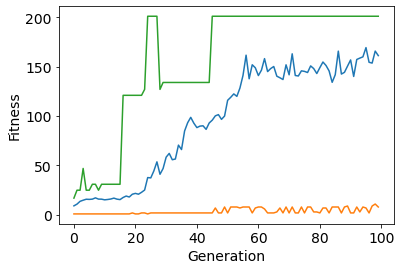

In [ ]:
logbook.header = "gen", "avg", "evals", "std", "min", "max"

import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.select("gen")
_min = logbook.select("min")
_max = logbook.select("max")
avgs = logbook.select("avg")
stds = logbook.select("std")

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)


bestInd = tools.selBest(pop, 1)[0]
myNet.setWeightsLinear(bestInd)

print(logbook)

Below is what you would use for your evaluation. You would also use it to display your final (pickled and loaded) solution, with headless = False.

If you have run without headless (i.e. with the display) you will need to reset your kernel to run again. This appears to be an IPython issue with Turtle, but if you have a way to deal with that, do please let me know. You will probable only want to run it one-at-a-time anyway.

In [ ]:
if HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)
PRINT = True   
run_game(display, snake_game, False, myNet)

201